# Data Management Project: Bitcoin sentiment analysis

### Data sources:
- Bitcoin Volume: API endpoint -> https://api.binance.com/api/v3/klines
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [26]:
!pip install python-dotenv


[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
!pip install kafka-python pymongo

     -------------------------------------- 859.2/859.2 kB 4.5 MB/s eta 0:00:00
     -------------------------------------- 331.1/331.1 kB 6.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import requests
import json
from datetime import datetime
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import time

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pymongo import MongoClient

### BitCoin:

In [2]:
url = "https://api.binance.com/api/v3/klines"
params = {
    "symbol": "BTCUSDT",
    "interval": "1d",
    "limit": 10000
}

response = requests.get(url, params=params)
data = response.json()

# Converte le candele in un formato leggibile
candles = []
for c in data:
    open_time = datetime.fromtimestamp(c[0]/1000)   # converte ms → datetime
    open_price = float(c[1])
    high = float(c[2])
    low = float(c[3])
    close_price = float(c[4])

    candles.append({
        "date": open_time.strftime("%Y-%m-%d"),
        "open": open_price,
        "high": high,
        "low": low,
        "close": close_price
    })

for c in candles:
    print(c)


{'date': '2023-03-13', 'open': 21998.05, 'high': 24500.0, 'low': 21813.88, 'close': 24113.48}
{'date': '2023-03-14', 'open': 24112.27, 'high': 26386.87, 'low': 23976.42, 'close': 24670.41}
{'date': '2023-03-15', 'open': 24670.41, 'high': 25196.97, 'low': 23896.95, 'close': 24285.66}
{'date': '2023-03-16', 'open': 24285.66, 'high': 25167.4, 'low': 24123.0, 'close': 24998.78}
{'date': '2023-03-17', 'open': 24998.78, 'high': 27756.84, 'low': 24890.0, 'close': 27395.13}
{'date': '2023-03-18', 'open': 27395.13, 'high': 27724.85, 'low': 26578.0, 'close': 26907.49}
{'date': '2023-03-19', 'open': 26907.49, 'high': 28390.1, 'low': 26827.22, 'close': 27972.87}
{'date': '2023-03-20', 'open': 27972.87, 'high': 28472.0, 'low': 27124.47, 'close': 27717.01}
{'date': '2023-03-21', 'open': 27717.01, 'high': 28438.55, 'low': 27303.1, 'close': 28105.47}
{'date': '2023-03-22', 'open': 28107.81, 'high': 28868.05, 'low': 26601.8, 'close': 27250.97}
{'date': '2023-03-23', 'open': 27250.97, 'high': 28750.0, '

In [14]:
df = pd.DataFrame(candles) # Convert into DataFrame
df.head()

,date,open,high,low,close
0,2023-03-13,21998.05,24500.00,21813.88,24113.48
1,2023-03-14,24112.27,26386.87,23976.42,24670.41
2,2023-03-15,24670.41,25196.97,23896.95,24285.66
3,2023-03-16,24285.66,25167.40,24123.00,24998.78
4,2023-03-17,24998.78,27756.84,24890.00,27395.13


In [13]:
df.isna().sum() # There is no Missing Values

date     0
open     0
high     0
low      0
close    0
dtype: int64

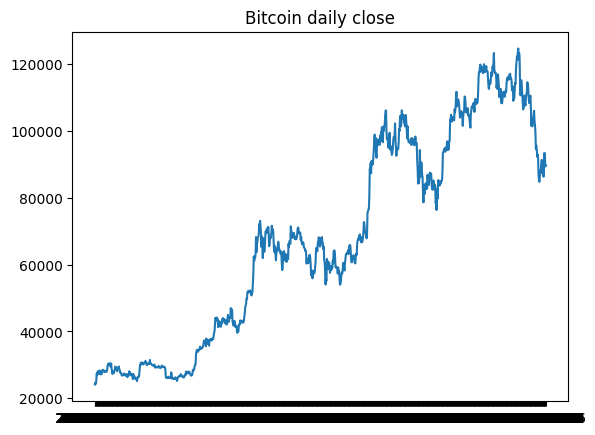

In [15]:
plt.figure()
plt.plot(df['date'],df['close'])
plt.title("Bitcoin daily close")
plt.show()

### NyTimes article:

In [16]:
load_dotenv()
key = os.getenv("NY_KEY") # your api key
query = 'Bitcoin'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [17]:
nyresponse = requests.get(url).json()
nyresponse

{'status': 'OK',
 'copyright': 'Copyright (c) 2025 The New York Times Company. All Rights Reserved.',
 'response': {'docs': [{'abstract': 'Bitcoin has plunged more than 30 percent and Ether is down around 40 percent in recent months, as gains from President Trump’s pro-crypto policies evaporated.',
    'byline': {'original': 'By David Yaffe-Bellany and Kailyn Rhone'},
    'document_type': 'article',
    'headline': {'main': 'Those Sky-High Bitcoin Prices Everyone Said Were Here to Stay? They Left.',
     'kicker': '',
     'print_headline': 'Those Sky-High Prices Forecast for Bitcoin? They Didn’t Pan Out.'},
    '_id': 'nyt://article/8e021b81-4ea1-5475-b807-1ae1c42219b5',
    'keywords': [{'name': 'Subject', 'value': 'Virtual Currency', 'rank': 1},
     {'name': 'Subject',
      'value': 'United States Politics and Government',
      'rank': 2},
     {'name': 'Subject', 'value': 'Bitcoin (Currency)', 'rank': 3},
     {'name': 'Subject',
      'value': 'Regulation and Deregulation of In

In [18]:
len(nyresponse["response"]["docs"])

10

In [19]:
i = 1
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [19]:
nyresponse = requests.get(url).json()

nyresponse

with open("nytimes.json", "w", encoding="utf-8") as f:
    json.dump(nyresponse, f, ensure_ascii=False, indent=4)

In [11]:
key = os.getenv("NY_KEY")
query = 'crypto'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

nyresponse = requests.get(url).json()

nyresponse

{'fault': {'faultstring': 'Invalid ApiKey',
  'detail': {'errorcode': 'oauth.v2.InvalidApiKey'}}}

In [ ]:
# Definition of the Kafka Producer:

producer = KafkaProducer(
    bootstrap_servers="localhost:9092",
    value_serializer=lambda v: json.dumps(v).encode("utf-8")
)



1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


In [53]:
key = os.getenv("NY_KEY") # your key
query = ["Bitcoin", "Crypto"] # search for Bitcoin and Crypto in general
for i in range(100): # Set 100 pages
    for q in query: # one call for each query
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}' # update url 

        try:
            response = requests.get(url)
            response.raise_for_status()  # raise error for non-200 responses
            
            data = response.json()

            TOPIC = q

            # send only if the response is valid
            producer.send(TOPIC, data)
            print(f"Send result for '{q}', page {i}")

        except Exception as e: 
            print(f"Error in ='{q}', page={i}: {e}")
            continue  # skip

        time.sleep(15)



        

Send result for 'Bitcoin', page 0
Send result for 'Crypto', page 0
Send result for 'Bitcoin', page 1
Send result for 'Crypto', page 1
Send result for 'Bitcoin', page 2
Send result for 'Crypto', page 2
Send result for 'Bitcoin', page 3
Send result for 'Crypto', page 3
Send result for 'Bitcoin', page 4
Send result for 'Crypto', page 4
Send result for 'Bitcoin', page 5
Send result for 'Crypto', page 5
Send result for 'Bitcoin', page 6
Send result for 'Crypto', page 6
Send result for 'Bitcoin', page 7
Send result for 'Crypto', page 7
Send result for 'Bitcoin', page 8
Send result for 'Crypto', page 8
Send result for 'Bitcoin', page 9
Send result for 'Crypto', page 9
Send result for 'Bitcoin', page 10
Send result for 'Crypto', page 10
Send result for 'Bitcoin', page 11
Send result for 'Crypto', page 11
Send result for 'Bitcoin', page 12
Send result for 'Crypto', page 12
Send result for 'Bitcoin', page 13
Send result for 'Crypto', page 13
Send result for 'Bitcoin', page 14
Send result for 'Cr

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [49]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",          # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000

)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)



In [ ]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_pr2']

collection = db['Article']

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


Waiting for Bitcoin messages...
Waiting for Crypto messages...
All messages consumed.


In [52]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")
# Conta articoli per query specifica
num_bitcoin = collection.count_documents({'query': 'Bitcoin'})
num_crypto = collection.count_documents({'query': 'Crypto'})

print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")



Number of articles in the collection: 111
Number of Bitcoin articles: 111
Number of Crypto articles: 0


### Other news API:

In [22]:
key = os.getenv("NEWS_KEY")
url = ('https://newsapi.org/v2/everything?'
       'q=Bitcoin&'
       'from=2025-11-05&'
       'sortBy=popularity&'
       f'apiKey={key}')

In [23]:
news_resp = requests.get(url).json()
news_resp

{'status': 'ok',
 'totalResults': 14458,
 'articles': [{'source': {'id': 'wired', 'name': 'Wired'},
   'author': 'Joel Khalili',
   'title': 'Inside a Wild Bitcoin Heist: Five-Star Hotels, Cash-Stuffed Envelopes, and Vanishing Funds',
   'description': 'Sophisticated crypto scams are on the rise. But few of them go to the lengths one bitcoin mining executive experienced earlier this year.',
   'url': 'https://www.wired.com/story/bitcoin-scam-mining-as-service/',
   'urlToImage': 'https://media.wired.com/photos/6913b909f757bec53ccf7811/191:100/w_1280,c_limit/Bitcoin-Heist-Business-1304706668.jpg',
   'publishedAt': '2025-11-17T10:00:00Z',
   'content': 'As Kent Halliburton stood in a bathroom at the Rosewood Hotel in central Amsterdam, thousands of miles from home, running his fingers through an envelope filled with 10,000 in crisp banknotes, he sta… [+2362 chars]'},
  {'source': {'id': 'the-verge', 'name': 'The Verge'},
   'author': 'Elizabeth Lopatto',
   'title': 'I looked into CoreW